In [1]:
## Solving Aiyagari Model (1994)
# 08.12.2024
# Author @ Iman Taghaddosinejad (https://github.com/iman-nejad)
#**********************************************************************************
# This file computes a stationary RE-RCE using VFI + Howard Improvement
#**********************************************************************************
# This file incorporates techniques used by Hanbaek Lee in his code 
# (see https://github.com/hanbaeklee/ComputationLab). All mistakes are my own.
#**********************************************************************************
# Outline of Algorithm:
# 1. Parameterization
# 2. Guess price(s) or Aggregate(s)
# 3. Solve HH optimizaiton problem using VFI + Howard Improvement 
# 4. Compute staitonary distribution using non-stochastic itarative method
# 5. update price(s)/Aggregate(s)
# 6. Check convergence, if not repeat steps 3-6. 
#**********************************************************************************

In [2]:
## Importing Libraries and Helper Functions ## 
import numpy as np # type: ignore
from numba import njit
from scipy.optimize import minimize # type: ignore
from scipy.interpolate import interp1d # type: ignore
from quantecon.markov import tauchen 
import time

from Functions.fnMCss import fnMCss
from Functions.fnInterp1dGrid import fnInterp1dGrid
from Functions.fnInterp1dGridNumba import fnInterp1dGridNumba
from Functions.fnHHobj import fnHHobj
from Functions.fnOptaprime import fnOptaprime

In [3]:
## Define Class - GE Solver ## 

class GE_Solver:
    def __init__(self, initAggK):        
        # Aiyagari (1994) 
        self.pAlpha  = 0.36 
        self.pBeta   = 0.96
        self.pDelta  = 0.08 
        self.pTFP      = 1 

        # Income process (log(z) = pRho*log(z(-1)) + eps)
        self.pMu     = 0.0
        self.pSigma  = 0.2
        self.pRho    = 0.90
        self.pNz     = 7

        # Wealth grid Parameters   
        self.pNa1    = 50 # sparse grid for fast VFI  
        self.pNa2    = 100 # finer grid for interpolation 
        self.minGrida = 0
        self.maxGrida = 150
        self.curvelvl = 7

        # Loop parameters 
        self.wtOldK = 0.9900
        self.tolGE = 1e-8 
        self.tolVFI = 1e-8
        self.tolDist = 1e-8
        self.maxGEiter = 2000
        self.maxVFIiter = 2000 
        self.convergedGe = False 
        self.convergedVFI = False
        self.convergedDist = False

        # Initial Guess
        self.aggK = initAggK 

        # Placeholders
        self.vGrida1 = None 
        self.vGrida2 = None
        self.mVF = None 
        self.mVFnew = None 
        self.mPolaprime1 = None 
        self.mPolaprime2 = None 
        self.mPolc = None
        self.currentDist = None  
        self.marginalDista = None
        self.aggKnew = None

    ##======================================================================##
    ##  Define Grid(s)  
    ##======================================================================##
    
    # coarsed wealth grid (Maliar, Maliar, and Valli, 2010)
    def GridCreateWealth(self):
        x1 = np.linspace(0, 0.5, self.pNa1)
        x2 = np.linspace(0, 0.5, self.pNa2)
        y1 = x1**self.curvelvl / np.max(x1**self.curvelvl)
        y2 = x2**self.curvelvl / np.max(x2**self.curvelvl)
        vGrida1 = self.minGrida + (self.maxGrida - self.minGrida) * y1 
        vGrida2 = self.minGrida + (self.maxGrida - self.minGrida) * y2
        return vGrida1, vGrida2

    # productivity grid 
    def GridCreateProductivity(self):
        """
        QuantEcon Tauchen Module: 
        y(t) = mu + rho * y(t-1) + eps(t), where eps(t) ~ iid N(0, sigma^2)
        """
        mc = tauchen(rho=self.pRho, sigma=self.pSigma, mu=self.pMu, n=self.pNz, n_std=3)
        vZ = np.exp(mc.state_values)
        mTz = mc.P 
        vPiz = fnMCss(np.transpose(mTz), eigvlmethod=True) # stationary distribution
        return vZ, mTz, vPiz
    
    ##======================================================================##
    ## Define Loop Functions 
    ##======================================================================##
        
    @staticmethod
    @njit
    def VFI_accelerated(pNz, pNa1, vGrida1,
                        mPolaprime1, mPolc, pBeta, mVFnew,
                        expVF
                        ):
        for iz in range(pNz):
            expVFz = expVF[:, iz] # expected VF conditioned on current income state
            for ia in range(pNa1):
                aprime = mPolaprime1[ia, iz]
                c = mPolc[ia, iz] 
                aLow, aHigh, wtLow, wtHigh = fnInterp1dGridNumba(aprime, vGrida1, pNa1)
                value = wtLow*expVFz[aLow] + wtHigh*expVFz[aHigh]
                mVFnew[ia, iz] = np.log(c) + pBeta * value       
        return mVFnew
    
    def VFI_non_accelerated(self, expVF, w, r, vZ):        
        for iz in range(self.pNz):
            expVFz = expVF[:, iz] # expected VF conditioned on current income state
            minwealth = self.minGrida # reset lower bound on optimal savings 
            for ia in range(self.pNa1):

                # compute optimal savings and consumption
                budget = w * vZ[iz] + (1+r) * self.vGrida1[ia]
                aprime = fnOptaprime(
                    objargs=(self.pBeta, budget, self.vGrida1, self.pNa1, expVFz), 
                    amin=minwealth, amax=budget)
                c = np.maximum(1e-8, budget - aprime)

                # interpolate VF on the asset-grid corresponding to aprime
                aLow, aHigh, wtLow, wtHigh = fnInterp1dGrid(aprime, self.vGrida1, self.pNa1)
                value = wtLow*expVFz[aLow] + wtHigh*expVFz[aHigh]

                # update VF and PFs 
                self.mVFnew[ia, iz] = np.log(c) + self.pBeta * value 
                self.mPolaprime1[ia, iz] = aprime 
                self.mPolc[ia, iz] = c
                
                # update minimum wealth to take advtage of monotonicity in policy rule 
                minwealth = aprime         
        return self.mVFnew, self.mPolaprime1, self.mPolc
    
    def VFSolver(self, w, r, mTz, vZ):                
        errVFI = 20
        iterVFI = 1
        while errVFI >= self.tolVFI and iterVFI <= self.maxVFIiter:
            expVF = np.dot(self.mVF, np.transpose(mTz)) # expected VF

            #---------- VFI w/ Policy Function Computation (Non-Accelerated) ----------#
            if iterVFI <= 30 or iterVFI % 20 == 0:                
                self.mVFnew, self.mPolaprime1, self.mPolc = self.VFI_non_accelerated(expVF, w, r, vZ)

            #---------- VFI w/o Policy Function Computation (Accelerated) ----------#
            else:
                self.mVFnew = self.VFI_accelerated(self.pNz, self.pNa1, self.vGrida1,
                                                   self.mPolaprime1, self.mPolc, self.pBeta, self.mVFnew, 
                                                   expVF)                
            # compute error
            errVFI = np.max(np.abs(self.mVFnew - self.mVF))
            # update VF 
            self.mVF = np.copy(self.mVFnew)
            iterVFI += 1        
        return self.mVF, self.mPolaprime1, self.mPolc, errVFI

    def StationaryDist(self, mTz):
        #---------- Non-stochastic Iterative (Histogram) Method ----------#        

        aprime = self.mPolaprime2 # optimal savings rule over finer grid 
        LB, UB, wtLB, wtUB = fnInterp1dGrid(aprime, self.vGrida2, self.pNa2) # interpolate entire policy rule/function at once using broadcasting  
        oldDist = np.copy(self.currentDist)
        errDist = 20 
        while errDist >= 1e-8:                        
            mass = oldDist # reset mass as current distribution (over all asset-productivity states (ia,iz))         
            newDist = np.zeros(oldDist.shape) # new distribution reset to zero
            for iznext in range(self.pNz):
                newMass = mass * mTz[:, iznext] # compute new mass for ALL current states (ia, iz) transitioning to iznext using broadcasting

                # VECTORIZED MASS ALLOCATION USING ADVANCED INDEXING
                # LB[ia,iz] gives destination asset grid index for mass from current state [ia,iz]
                # wtLB[ia,iz] is interpolation weight for transitioning from ia to LB[ia,iz] (asset level only)
                # use LB[ia,iz] as row indices and update mass according to wtLB[ia,iz] * newMass[ia,iz] to newDist[LB[ia,iz], iznext]
                # Transition probs depend only on z-states. Mass movement: [ia,iz] -> [LB[ia,iz], iznext] with weight wtLB[ia,iz]
                np.add.at(newDist, (LB, iznext), wtLB * newMass)
                np.add.at(newDist, (UB, iznext), wtUB * newMass)
            
            errDist = np.max(np.abs(newDist - oldDist))
            oldDist = np.copy(newDist)
        return oldDist
    
    ##======================================================================##
    ## Define Solver 
    ##======================================================================##

    def GEloop(self):
        # set grids 
        self.vGrida1, self.vGrida2 = self.GridCreateWealth()
        vZ, mTz, vPiz = self.GridCreateProductivity()
        # initialize 
        self.mVF = np.transpose(np.tile(0.01 * self.vGrida1, (self.pNz, 1))) 
        self.mVFnew = np.zeros(self.mVF.shape) 
        self.mPolaprime1 = np.zeros((self.pNa1, self.pNz)) 
        self.mPolaprime2 = np.zeros((self.pNa2, self.pNz)) 
        self.mPolc = np.zeros((self.pNa1, self.pNz))
        self.currentDist = np.ones((self.pNa2, self.pNz))
        self.currentDist = self.currentDist / (self.pNa2 * self.pNz)              
        aggL = np.dot(vPiz, vZ) # agg labour supply (exog. - inelastic)
    
        ## OUTER LOOP (GE) ------------------------------## 
        cuml_time = 0 
        errGE = 20 
        iterGE = 1
        while errGE >= self.tolGE and iterGE <= self.maxGEiter: 

            start_ge = time.time()    
            r = self.pAlpha * self.pTFP * (self.aggK / aggL)**(self.pAlpha - 1) - self.pDelta # real rate 
            w = (1-self.pAlpha) * self.pTFP * (self.aggK / aggL)**(self.pAlpha) # wage rate 

            ## INNER LOOP ------------------------------##
            start_time = time.time()
            self.mVF, self.mPolaprime1, self.mPolc, errVFI = self.VFSolver(w, r, mTz, vZ) 
            end_time = time.time() 
            print(f"VF Converged in {end_time - start_time: .3f}s")

            ## INTERPOLATE POLICY RULE ------------------------------##
            fnLinInterp = interp1d(self.vGrida1, self.mPolaprime1, kind='linear', fill_value='extrapolate', axis=0)
            self.mPolaprime2 = fnLinInterp(self.vGrida2)

            ## COMPUTE STATIONARY DISTRIBUTION ------------------------------## 
            start_time = time.time() 
            self.currentDist = self.StationaryDist(mTz)
            end_time = time.time() 
            print(f"Distribution Converged in {end_time - start_time: .3f}s")

            ## COMPUTE NEW AGG (K) CAPITAL ------------------------------##
            self.marginalDista = np.sum(self.currentDist, axis=1) # marginal distribution of wealth (a) over income states (z)
            self.aggKnew = np.dot(self.vGrida2, self.marginalDista) # Capital Market Clearing - New/Endog. Capital

            ## COMPUTE ERROR ------------------------------##            
            errGE = np.abs(self.aggKnew - self.aggK)

            ## UPDATE AGGREGATES ------------------------------##
            self.aggK = self.wtOldK*self.aggK + (1-self.wtOldK)*self.aggKnew # conservative updating using convex combination of old and new values 
            iterGE += 1

            ## PRINT PROGRESS ------------------------------##
            end_ge = time.time()
            cuml_time += end_ge - start_ge        
            print(f"\n GE Iteration: {iterGE} After {cuml_time/60: .3n} minutes. Error: {errGE: .8f}")
            print(f"AggK: {self.aggK: .4f}")
            print(f"r: {r: .4f}, w: {w: .4f}")
            print("-"*50)
            
        if errGE < self.tolGE: self.convergedGe = True
        if errVFI < self.tolVFI: self.convergedVFI = True
        return {
            'VF': self.mVF,
            'mPolaprime': self.mPolaprime2,
            'mPolc': self.mPolc,
            'distribution': self.currentDist,
            'aggK': self.aggK,
            'interest_rate': r,
            'wage_rate': w,
            'grids': {
                'vGrida1': self.vGrida1,
                'vGrida2': self.vGrida2,
                'vZ': vZ
            },
            'convergence_result': {
                'convergedGE' : self.convergedGe,
                'convergedVFI' : self.convergedVFI
            }
        } 

In [4]:
## Solve Aiyagari Model (1994) ##

Aiyagari1994Solver = GE_Solver(initAggK=7.2)
Aiyagari1994Solver_results = Aiyagari1994Solver.GEloop()

VF Converged in  20.552s
Distribution Converged in  0.833s

 GE Iteration: 2 After  0.357 minutes. Error:  0.38728313
AggK:  7.1961
r:  0.0316, w:  1.2370
--------------------------------------------------
VF Converged in  16.762s
Distribution Converged in  0.248s

 GE Iteration: 3 After  0.64 minutes. Error:  0.35476653
AggK:  7.1926
r:  0.0316, w:  1.2367
--------------------------------------------------
VF Converged in  14.940s
Distribution Converged in  0.223s

 GE Iteration: 4 After  0.893 minutes. Error:  0.32457074
AggK:  7.1893
r:  0.0316, w:  1.2365
--------------------------------------------------
VF Converged in  12.768s
Distribution Converged in  0.202s

 GE Iteration: 5 After  1.11 minutes. Error:  0.29676196
AggK:  7.1864
r:  0.0317, w:  1.2363
--------------------------------------------------
VF Converged in  12.760s
Distribution Converged in  0.199s

 GE Iteration: 6 After  1.33 minutes. Error:  0.27117608
AggK:  7.1837
r:  0.0317, w:  1.2361
------------------------

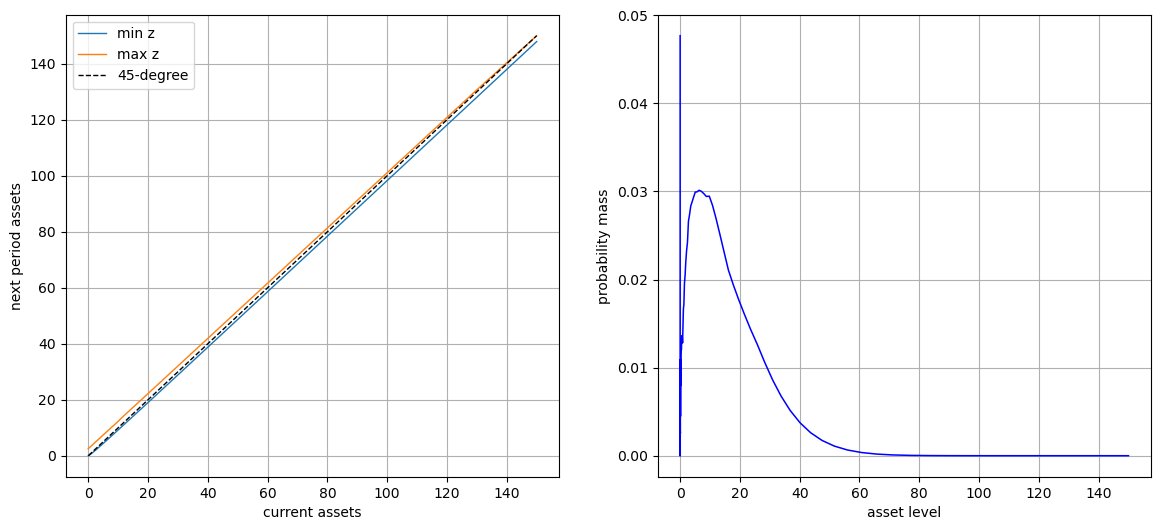

In [5]:
## Some Figures ## 

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(Aiyagari1994Solver_results['grids']['vGrida2'], 
            Aiyagari1994Solver_results['mPolaprime'][:, 0], linewidth=1, label='min z')
axs[0].plot(Aiyagari1994Solver_results['grids']['vGrida2'], 
            Aiyagari1994Solver_results['mPolaprime'][:, 6], linewidth=1, label='max z')
axs[0].plot(Aiyagari1994Solver_results['grids']['vGrida2'], 
            Aiyagari1994Solver_results['grids']['vGrida2'], 'k--', linewidth=1, label='45-degree')
axs[0].set_xlabel('current assets')
axs[0].set_ylabel('next period assets')
axs[0].grid(True)
axs[0].legend()

Aiyagari1994Solver_results['marginalDista'] = np.sum(Aiyagari1994Solver_results['distribution'], axis=1)
axs[1].plot(Aiyagari1994Solver_results['grids']['vGrida2'], 
            Aiyagari1994Solver_results['marginalDista'], linewidth=1.1, c='blue')
axs[1].set_xlabel('asset level')
axs[1].set_ylabel('probability mass')
axs[1].grid(True)

plt.show()